# Fluorescence polarization

In [1]:
from io import StringIO
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

In [2]:
folder = Path('data/fluorescence-polarization') # specify path to your data

In [3]:
def read(csv_file: Path):
    content = csv_file.read_text()
    data = content.partition('\n\n')[0]
    file = StringIO(data)
    df = pd.read_csv(file, skiprows=2,
                     names=['wavelength', 'intensity'], usecols=[0, 1])
    return df

In [4]:
def get_data(folder: Path):
    d = {}
    for p in folder.glob('*.csv'):
        d[p.stem] = read(p)
    return pd.Series(d)

In [5]:
all_data = get_data(folder).sort_index()

In [6]:
def peaks(all_data):

    fig, axs = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(10, 10))

    Z = zip(
        range(1, len(all_data) + 1),
        all_data.items(),
        axs.ravel()
    )

    result = {}

    for i, (k, data), ax in Z:
        
        data.plot(x=0, y=1, ax=ax)

        smooth = gaussian_filter1d(data.intensity, 2) # smooth factor
        [peak_idx], _ = find_peaks(smooth) # should be only 1 peak, increase smooth factor
        data.iloc[[peak_idx]].plot(x=0, y=1, style='.r', ax=ax)
        wl, int_ = data.iloc[peak_idx]

        title = '№ {no} : $\lambda = {wl:.0f}$, $I_{{{idxs}}} = {int:.2f}$'.format(
            no=k[0], wl=wl,
            idxs=','.join(k[1:]), int=int_
        )

        ax.set_title(title)
        ax.get_legend().remove()

        result[(k[0], k[1:])] = int_

    plt.tight_layout()

    return pd.Series(result).unstack(level=1)

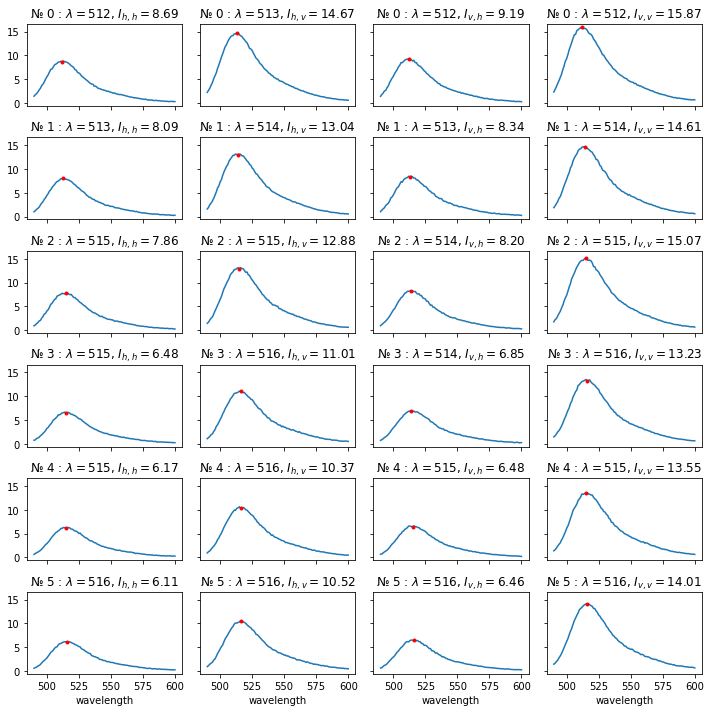

In [7]:
intensities = peaks(all_data)

In [8]:
intensities['g_factor'] = intensities.hv / intensities.hh
intensities['polarization'] = intensities.apply(lambda x: (x.vv - x.g_factor * x.vh) / (x.vv + x.g_factor * x.vh), axis=1)

In [9]:
intensities

,hh,hv,vh,vv,g_factor,polarization
0,8.692522,14.668288,9.187510,15.867807,1.687461,0.011611
1,8.085460,13.035077,8.340162,14.611181,1.612163,0.041540
2,7.856707,12.878545,8.202553,15.067453,1.639178,0.056887
3,6.478344,11.011899,6.853699,13.229930,1.699802,0.063505
4,6.167875,10.369456,6.478917,13.547698,1.681204,0.108646
5,6.111468,10.518697,6.460008,14.011591,1.721141,0.115121
